In [19]:
(* parameters *)
(* 最大次数 *)
maxOrderNum = 200;
(* 画像URL, もしくはローカルパス *)
imageURL = "https://www.google.com/images/branding/googlelogo/2x/googlelogo_color_160x56dp.png";
 
pointListToLines[pointList_, neighbothoodSize_: 6] :=
 Module[{L = DeleteDuplicates[pointList], NF, lambda,
   lineBag, counter, seenQ, sLB, nearest,
   nearest1, nextPoint, couldReverseQ, d, n, s},
  NF = Nearest[L];
  lambda = Length[L];
  Monitor[
   (*list of segments *)
   lineBag = {};
   counter = 0;
   While[counter < lambda,
    (*new segment*)
    sLB = {RandomChoice[DeleteCases[L, _?seenQ]]};
    seenQ[sLB[[1]]] = True;
    counter++;
    couldReverseQ = True;
    (*complete segment*)
    While[
     (nearest = NF[Last[sLB], {Infinity, neighbothoodSize}];
      nearest1 = 
       SortBy[DeleteCases[nearest, _?seenQ], 
        1. EuclideanDistance[Last[sLB], #] &];
      nearest1 =!= {} || couldReverseQ),
     If[
      nearest1 === {},
      (*extend the other end; penalize sharp edges*)
      sLB = Reverse[sLB]; 
      couldReverseQ = False,
      
      (* prefer straight continuation *)
      nextPoint = If[Length[sLB] <= 3,
        nearest1[[1]],
        d = 1. Normalize[(sLB[[-1]] - sLB[[-2]]) +
            1/2 (sLB[[-2]] - sLB[[-3]])];
        n = {-1, 1} Reverse[d];
        s = Sort[{Sqrt[(d.(# - sLB[[-1]]))^2 +
               (*perpendicular *)2
                (n. (# - sLB[[-1]]))^2], #} & /@ nearest1];
        s[[1, 2]]];
      AppendTo[sLB, nextPoint];
      seenQ[nextPoint] = True;
      counter++]];
    AppendTo[lineBag, sLB]];
   (*return segments sorted by length*)
   Reverse[SortBy[Select[lineBag, Length[#] > 12 &],
     Length]],
   (*monitor progress*)
   Grid[
    {{Text[Style["progress point joining",
        Darker[Green, 0.66]]],
      ProgressIndicator[counter/lambda]},
     {Text[Style["number of segments",
        Darker[Green, 0.66]]],
      Length[lineBag] + 1}},
    Alignment -> Left, Dividers -> Center]]]
 
(* Fourier coefficients of a single curve *)
fourierComponentData[pointList_, nMax_, op_] :=
 Module[{epsilon = 10^-3, myu = 2^14, M = 10000, s, scale, delta, L, 
   nds, sMax, if, xyFunction, X, Y, XFT, YFT, type},
  (* prepare curve *)
  scale = 
   1. Mean[Table[
      Max[fl /@ pointList] - 
       Min[fl /@ pointList], {fl, {First, Last}}]];
  delta = EuclideanDistance[First[pointList], Last[pointList]];
  L = Which[
    op === "Closed",
    type = "Closed";
    If[First[pointList] === Last[pointList], pointList,
     Append[pointList, First[pointList]]],
    
    op === "Open",
    type = "Open";
    pointList,
    
    delta == 0.,
    type = "Closed";
    pointList,
    
    delta/scale < op,
    type = "Closed";
    Append[pointList, First[pointList]],
    
    True,
    type = "Open";
    Join[pointList, Rest[Reverse[pointList]]]];
  (*re-parametrize curve by arclength *)
  xyFunction = BSplineFunction[L, SplineDegree -> 4];
  nds = NDSolve[
    {s'[t] == Sqrt[xyFunction'[t].xyFunction'[t]],
     s[0] == 0}, s, {t, 0, 1}, MaxSteps -> 10^5, PrecisionGoal -> 4];
  (* total curve length *)
  sMax = s[1] /. nds[[1]];
  if = Interpolation[
    Table[{s[rho] /. nds[[1]], rho}, {rho, 0, 1, 1/M}]];
  X[t_Real] := 
   BSplineFunction[L][Max[Min[1, if[(t + Pi)/(2 Pi) sMax]], 0]][[1]];
  Y[t_Real] := 
   BSplineFunction[L][Max[Min[1, if[(t + Pi)/(2 Pi) sMax]], 0]][[2]];
  (* extract Fourier coefficients *)
  {XFT, YFT} = 
   Fourier[Table[#[N@t], {t, -Pi + epsilon, 
        Pi - epsilon, (2 Pi - 2 epsilon)/myu}]] & /@ {X, Y};
  {type, 2 Pi/
     Sqrt[myu]*((Transpose[
         Table[{Re[#], Im[#]} &[Exp[I k Pi] #[[k + 1]]], {k, 0, 
           nMax}]] & /@ {XFT, YFT}))}]
Options[fourierComponents] =
  {"MaxOrder" -> maxOrderNum, "OpenClose" -> 0.025};
 
fourierComponents[pointLists_, OptionsPattern[]] :=
 Monitor[
   Table[fourierComponentData[
     pointLists[[k]],
     If[Head[#] === List, #[[k]], #] &[OptionValue["MaxOrder"]],
     If[Head[#] === List, #[[k]], #] &[OptionValue["OpenClose"]]
     ], {k, Length[pointLists]}],
   Grid[
    {{Text[
       Style[
        "progress calculating Fourier coefficients",
        Darker[Green, 0.66]]],
      ProgressIndicator[k/Length[pointLists]]}},
    Alignment -> Left, Dividers -> Center]] /; Depth[pointLists] === 4
 
makeFourierSeries[
  {"Closed" | "Open", {{cax_, sax_}, {cay_, say_}}},
  t_, n_] :=
 {Sum[If[k == 0, 1/2, 1] cax[[k + 1]] Cos[k t] + 
    sax[[k + 1]] Sin[k t], {k, 0, Min[n, Length[cax]]}],
  Sum[If[k == 0, 1/2, 1] cay[[k + 1]] Cos[k t] + 
    say[[k + 1]] Sin[k t], {k, 0, Min[n, Length[cay]]}]}
 
paraplot[n_] :=
 Show[
  {ParametricPlot[
    Evaluate[makeFourierSeries[#, t, n] & /@ fCs],
    {t, -Pi, Pi}, Axes -> False](*,
   Graphics[Text[Style["n="<>ToString[n],Large,Bold],
   Scaled[{.9,.1}] ]]*)}(*,ImageSize->{500,500}*)]
   

In [65]:
imgData = "../data/resize_image.jpg"

../data/resize_image.jpg


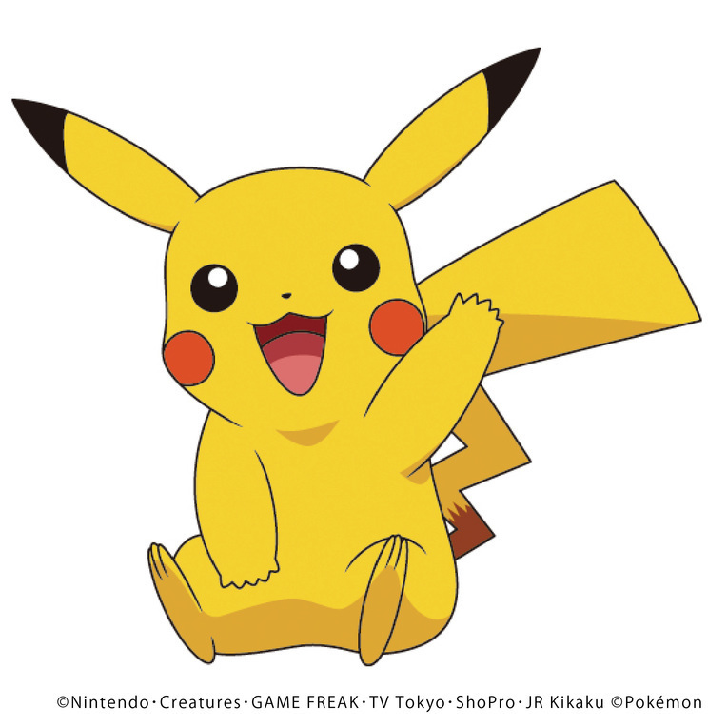

In [66]:
img = Import[imgData]

FrontEndObject::notavail: 
 A front end is not available; certain operations require a front end.
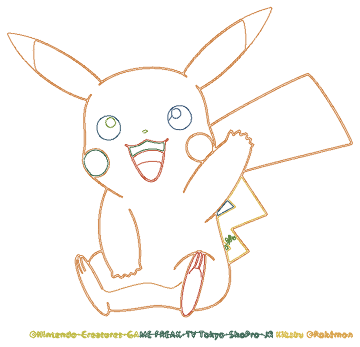

In [67]:
edgeImage = Thinning[EdgeDetect[ColorConvert[
    ImagePad[Image[Map[Most, ImageData[img], {2}]], 20, White], 
    "Grayscale"]]];
data = ImageData[edgeImage];
pos = Position[data, 1, {2}];
edgePoints = Apply[{#2, -#1} &, pos, {1}];
SeedRandom[2];
hLines = pointListToLines[edgePoints, 16];
Graphics[{ColorData["DarkRainbow"][RandomReal[]], Line[#]} & /@ hLines]

FrontEndObject::notavail: 
 A front end is not available; certain operations require a front end.
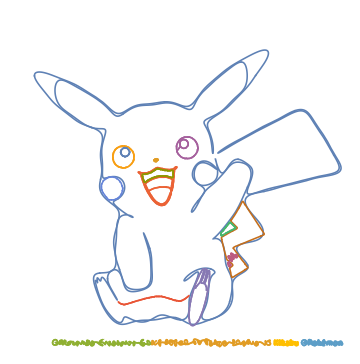

In [74]:
fCs = fourierComponents[hLines];
Show[ParametricPlot[
   Evaluate[makeFourierSeries[#, t, 100] & /@ fCs],
   {t, -Pi, Pi}, Axes -> False]]


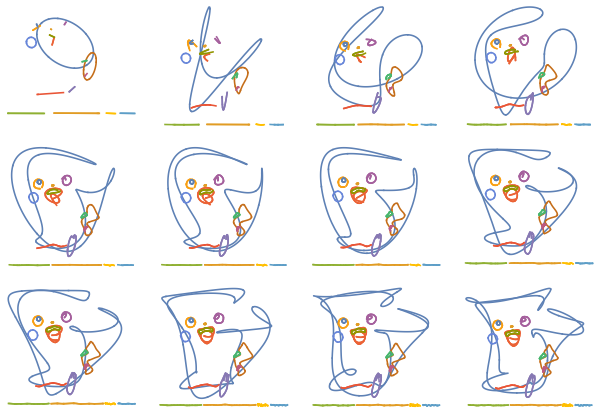

In [76]:
Partition[Table[paraplot[n], {n, 1, 12}], 4] // GraphicsGrid


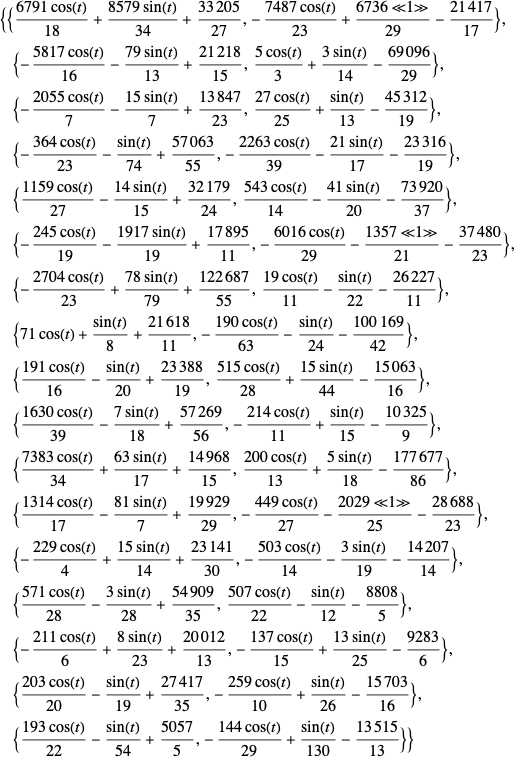

In [77]:
curves = makeFourierSeries[#, t, 1] & /@ fCs;
Style[Map[Short, Rationalize[curves, 0.002]], 16] // TraditionalForm

In [79]:
Dynamic[n]
Export["plot.gif", 
 Table[(n = x; paraplot[x]), {x, 1, maxOrderNum, 1}]]

Out[79]:
 
 
 
 
 Out[80]: